**Import Dependencies**

In [ ]:
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())


1.5.0+cu101 True


In [ ]:
!pip install cython pyyaml==5.1 pycocotools>=2.0.1

# PyTorch 1.5
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 

# OpenCV
!pip install opencv-contrib-python
!pip install dlib

# Detectron2
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/detectron2-0.1.3%2Bcu101-cp37-cp37m-linux_x86_64.whl (6.2 MB)
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu102
    Uninstalling detectron2-0.6+cu102:
      Successfully uninstalled detectron2-0.6+cu102


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
!curl -L "https://app.roboflow.com/ds/2artfkWYiV?key=pM6UbcZmoP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1377      0 --:--:-- --:--:-- --:--:--  1379
100 18.8M  100 18.8M    0     0  11.7M      0  0:00:01  0:00:01 --:--:-- 42.0M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/IMG_0018_JPG.rf.5c258573ad22229c8c41608221d20245.jpg  
 extracting: test/IMG_0024_JPG.rf.3ea8c7d70948e7c3fd8d1d2a7fc592c8.jpg  
 extracting: test/IMG_0030_JPG.rf.c31dd00f7479edde87463b4fccd0c42b.jpg  
 extracting: test/IMG_0032_JPG.rf.90f3891ac0a946542eb309b32a8b991d.jpg  
 extracting: test/IMG_0146_JPG.rf.102eeb96150933f512aa060a1cfbd0c5.jpg  
 extracting: test/IMG_0147_JPG.rf.194992b57dd5c12b7f53dbc26bb1e7fe.jpg  
 extracting: test/IMG_0152_JPG.rf.78617419179fb00cad2d2f21b1b01764.jpg  
 extracting: test/IMG_0153_JPG.rf.016c5103892e6de2c9f23

In [ ]:
from detectron2.structures import BoxMode

def get_medical_dicts(img_dir):
    json_file = os.path.join(img_dir, "_annotations.coco.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    #Creating a dataset dict containing all information about the images
    dataset_dicts = [] 
    for i,j in enumerate(range(len(imgs_anns['images']))):
        file_name = imgs_anns['images'][j]['file_name']
        record = {}
        filename = os.path.join(img_dir,file_name)
        height, width = cv2.imread(filename).shape[:2]
        record["file_name"] = filename
        record["image_id"] = i
        record["height"] = height
        record["width"] = width
        objs = []
        annos = imgs_anns['annotations'][j]['bbox']
        obj = {
            "bbox":annos,
            "bbox_mode": BoxMode.XYWH_ABS, 
            "category_id": 1,
        }
        #Make sure you give BoxMode.XYWH_ABS otherwise the bounding box won't be detected
        objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("medical_device_" + d, lambda d=d: get_medical_dicts("/content/" + d))
    MetadataCatalog.get("medical_device_" + d).set(thing_classes=["medicaldevice"])
medical_device_metadata = MetadataCatalog.get("my_dataset_train")
medical_device_metadata

Metadata(evaluator_type='coco', image_root='/content/train', json_file='/content/train/_annotations.coco.json', name='my_dataset_train', thing_classes=['medicaldevice', 'medicaldevice'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1})

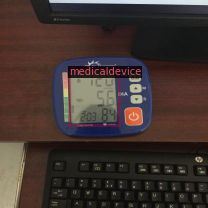

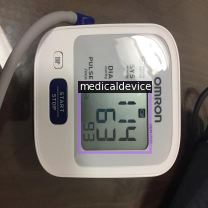

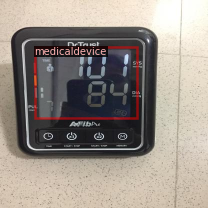

In [ ]:
dataset_dicts = get_medical_dicts("/content/train")
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=medical_device_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train_", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val_", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test_", {}, "/content/test/_annotations.coco.json", "/content/test")

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#Passing the Train and Validation sets
cfg.DATASETS.TRAIN = ("my_dataset_train_",)
cfg.DATASETS.TEST = ("my_dataset_test_",)
# Number of data loading threads
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
# Number of images per batch across all machines.
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0125  # pick a good LearningRate
cfg.SOLVER.MAX_ITER = 1500  #No. of iterations   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 # No. of classes = [HINDI, ENGLISH, OTHER]
cfg.TEST.EVAL_PERIOD = 500 # No. of iterations after which the Validation Set is evaluated. 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/20 04:47:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/20 04:47:08 d2.engine.train_loop]: Starting training from iteration 0
[11/20 04:47:43 d2.utils.events]:  eta: 0:43:48  iter: 19  total_loss: 1.281  loss_cls: 1.105  loss_box_reg: 0.167  loss_rpn_cls: 0.016  loss_rpn_loc: 0.007  time: 1.7622  data_time: 0.0378  lr: 0.000250  max_mem: 3318M
[11/20 04:48:19 d2.utils.events]:  eta: 0:43:45  iter: 39  total_loss: 0.416  loss_cls: 0.204  loss_box_reg: 0.212  loss_rpn_cls: 0.009  loss_rpn_loc: 0.005  time: 1.7830  data_time: 0.0167  lr: 0.000500  max_mem: 3318M
[11/20 04:48:53 d2.utils.events]:  eta: 0:42:39  iter: 59  total_loss: 0.407  loss_cls: 0.144  loss_box_reg: 0.249  loss_rpn_cls: 0.007  loss_rpn_loc: 0.004  time: 1.7596  data_time: 0.0202  lr: 0.000749  max_mem: 3318M
[11/20 04:49:29 d2.utils.events]:  eta: 0:42:14  iter: 79  total_loss: 0.356  loss_cls: 0.103  loss_box_reg: 0.239  loss_rpn_cls: 0.004  loss_rpn_loc: 0.004  time: 1.7697  data_time: 0.0190  lr: 0.000999  max_mem: 3318M
[11/20 04:50:05 d2.utils.events]:  eta: 0:41:5

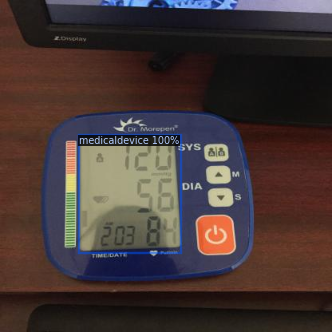

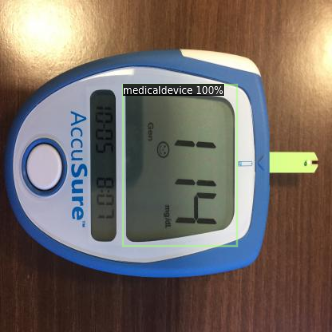

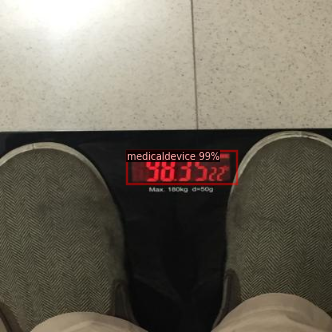

In [ ]:
from detectron2.utils.visualizer import ColorMode
medical_device_metadata = MetadataCatalog.get("my_dataset_test")
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("my_dataset_test_", )

predictor = DefaultPredictor(cfg)

dataset_dicts = get_medical_dicts("/content/test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=medical_device_metadata, 
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE   
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu")) #Passing the predictions to CPU from the GPU
    cv2_imshow(v.get_image()[:, :, ::-1])